Evaluating DAN model for FER task:

https://github.com/yaoing/dan

Eval Dataset:

https://osf.io/7a5fs/files/osfstorage


In [1]:
import numpy as np
import pandas as pd

import os
import cv2

from PIL import Image

import torch
from torchvision import transforms, models
from torch import nn
from torch.nn import functional as F
import torch.nn.init as init

from sklearn.metrics import accuracy_score



In [2]:
class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = models.resnet18(pretrained)
        
        if pretrained:
            checkpoint = torch.load('./models/resnet18_msceleb.pth')
            resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
   
        return out, x, heads

class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca


class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [3]:
data_transforms = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                ])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
emotions = ['neutral', 'happiness', 'sadness', 'surprise', 'fear', 'disgust', 'anger']

In [5]:
emotion_model = DAN(num_head=4, num_class=7, pretrained=False)
emotion_model.to(device)
checkpoint = torch.load('../checkpoints/affecnet7_epoch6_acc0.6569.pth', map_location=device)
emotion_model.load_state_dict(checkpoint['model_state_dict'], strict=True)
emotion_model.eval()

c:\Users\ashsy\OneDrive\Desktop\Git repositories\RT-Face-Emotion-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\ashsy\OneDrive\Desktop\Git repositories\RT-Face-Emotion-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ashsy\AppData\Local\Temp\ipykernel_46116\3678287634.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

DAN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
dataset_path = '../datasets/Emotional_faces/'

In [7]:
# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

face_cascade = cv2.CascadeClassifier('../src/haarcascade_frontalface_default.xml')

# Loop through each folder (each folder represents an id)
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load the image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)

            # If no faces are detected, skip this image
            if len(faces) == 0:
                print(f"No face detected in {img_path}, skipping")
                continue

            # extract the first face
            (x, y, w, h) = faces[0]
            # get roi
            roi = img[y:y + h, x:x + w]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            roi = Image.fromarray(roi)

            # preprocess according to paper
            roi_trf = data_transforms(roi).to(device)
            roi_trf = roi_trf.view(1, 3, 224, 224)

            with torch.no_grad():
                out, _, _ = emotion_model(roi_trf)
                _, pred = torch.max(out, 1)
                predicted_emotion = emotions[int(pred)]

            true_labels.append(img_name.split('.')[0].lower())  # Assuming the image name is the true label
            predictions.append(predicted_emotion)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 84.40%


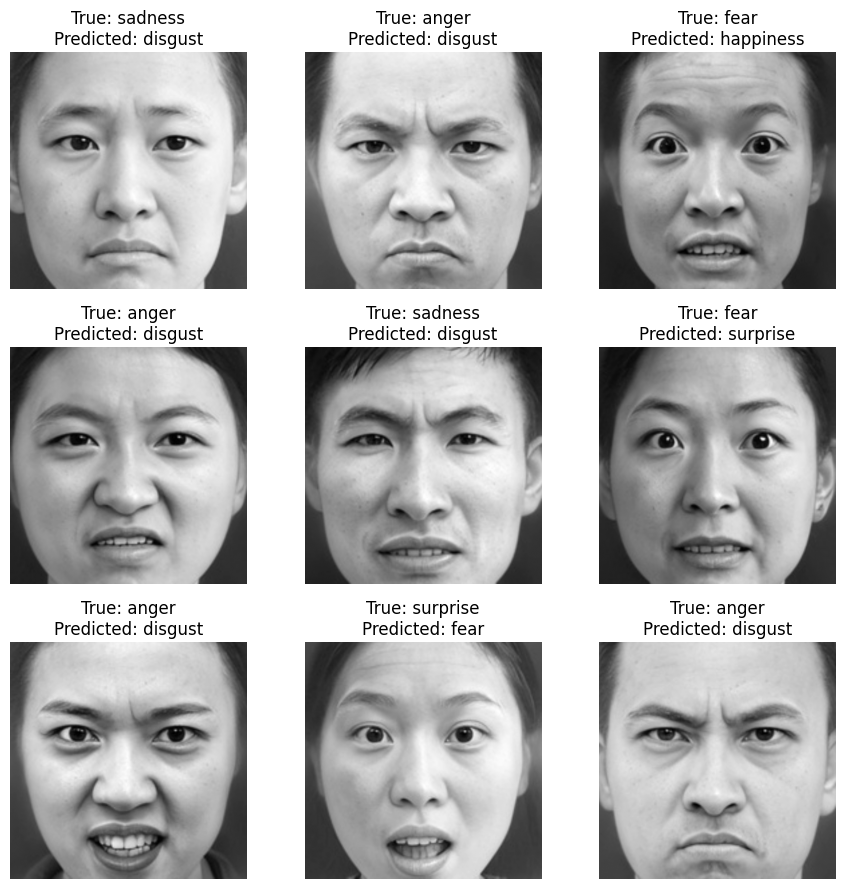

In [14]:
import random

import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

# Randomly sample up to 9 incorrect predictions
sample_size = min(9, len(incorrect_indices))
sampled_indices = random.sample(incorrect_indices, sample_size)

plt.figure(figsize=(9, 9))
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for i, index in enumerate(sampled_indices):
    img_found = False
    # Randomly shuffle folders to ensure we sample from different folders
    random.shuffle(folders)
    
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        img_path = os.path.join(folder_path, f'{true_labels[index].capitalize()}.jpg')
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
                if len(faces) > 0:
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face = cv2.resize(face, (480, 480))
                    img_found = True
                    break
            except:
                continue
    
    if img_found:
        plt.subplot(3, 3, i + 1)
        plt.imshow(face, cmap='gray')
        plt.title(f"True: {true_labels[index]}\nPredicted: {predictions[index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


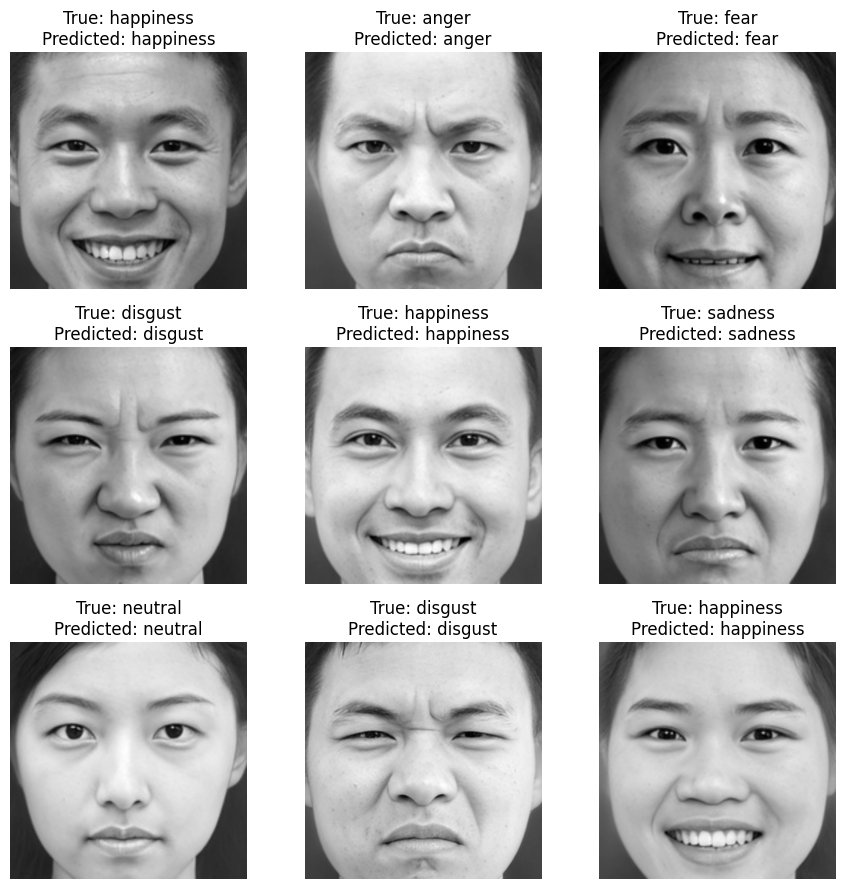

In [15]:
import random

import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]

# Randomly sample up to 9 correct predictions
sample_size = min(9, len(correct_indices))
sampled_indices = random.sample(correct_indices, sample_size)

plt.figure(figsize=(9, 9))
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for i, index in enumerate(sampled_indices):
    img_found = False
    # Randomly shuffle folders to ensure we sample from different folders
    random.shuffle(folders)
    
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        img_path = os.path.join(folder_path, f'{true_labels[index].capitalize()}.jpg')
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
                if len(faces) > 0:
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face = cv2.resize(face, (480, 480))
                    img_found = True
                    break
            except:
                continue
    
    if img_found:
        plt.subplot(3, 3, i + 1)
        plt.imshow(face, cmap='gray')
        plt.title(f"True: {true_labels[index]}\nPredicted: {predictions[index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.91      0.52      0.66       120
   happiness       0.58      0.98      0.73       120
     sadness       0.82      0.85      0.84       120
    surprise       0.94      0.99      0.97       120
        fear       0.99      0.97      0.98       120
     disgust       0.96      0.78      0.86       120
       anger       0.95      0.81      0.87       120

    accuracy                           0.84       840
   macro avg       0.88      0.84      0.84       840
weighted avg       0.88      0.84      0.84       840

